# **Time Series - Neural Network(LSTM)**

### ***Import Libraries and Dataset***

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.optim as optim
import math
from sklearn.metrics import mean_squared_error

In [4]:
data = pd.read_csv('UNRATE.csv')

In [5]:
data.head(2)

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8


### ***Cleaning***

In [6]:
data['DATE'] = pd.to_datetime(data['DATE'],format='%Y-%m-%d')
data['UNRATE'] = pd.to_numeric(data['UNRATE'], errors='coerce')
data.set_index('DATE', inplace=True)
data.head(3)

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0


## ***Pre-processing***

In [7]:
train_df = data.filter(['UNRATE'])
data_unscaled = train_df.values

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)


In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = train_df.columns.get_loc("UNRATE")
print(index_Close)

0


In [9]:
train_data_len = math.ceil(np_data.shape[0] * 0.95)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [10]:
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction

    # Convert the x and y to PyTorch tensors
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Ensure y is a column vector
    return x, y

In [11]:
# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([820, 50, 1]) torch.Size([820, 1])
torch.Size([45, 50, 1]) torch.Size([45, 1])


<ipython-input-10-42719d1c6080>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x = torch.tensor(x, dtype=torch.float32)


## **Model**

In [12]:

# Configure the neural network model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Get output from the last time step
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
# Hyperparameters
input_size = x_train.shape[2]
hidden_size = sequence_length
num_layers = 3
output_size = 1
learning_rate = 0.001
num_epochs = 500

In [17]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


### **Training**

In [18]:
# Training the model
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/500], Loss: 0.0630
Epoch [20/500], Loss: 0.0273
Epoch [30/500], Loss: 0.0207
Epoch [40/500], Loss: 0.0183
Epoch [50/500], Loss: 0.0176
Epoch [60/500], Loss: 0.0169
Epoch [70/500], Loss: 0.0150
Epoch [80/500], Loss: 0.0113
Epoch [90/500], Loss: 0.0092
Epoch [100/500], Loss: 0.0073
Epoch [110/500], Loss: 0.0058
Epoch [120/500], Loss: 0.0048
Epoch [130/500], Loss: 0.0044
Epoch [140/500], Loss: 0.0040
Epoch [150/500], Loss: 0.0037
Epoch [160/500], Loss: 0.0034
Epoch [170/500], Loss: 0.0031
Epoch [180/500], Loss: 0.0029
Epoch [190/500], Loss: 0.0026
Epoch [200/500], Loss: 0.0025
Epoch [210/500], Loss: 0.0024
Epoch [220/500], Loss: 0.0023
Epoch [230/500], Loss: 0.0023
Epoch [240/500], Loss: 0.0022
Epoch [250/500], Loss: 0.0022
Epoch [260/500], Loss: 0.0021
Epoch [270/500], Loss: 0.0020
Epoch [280/500], Loss: 0.0020
Epoch [290/500], Loss: 0.0019
Epoch [300/500], Loss: 0.0019
Epoch [310/500], Loss: 0.0020
Epoch [320/500], Loss: 0.0018
Epoch [330/500], Loss: 0.0018
Epoch [340/500], Lo

### **Evaluation**

In [19]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    y_pred_unscaled = mmscaler.inverse_transform(y_pred.detach().numpy())
    y_test_unscaled = mmscaler.inverse_transform(y_test.detach().numpy())


In [20]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.042425513267517


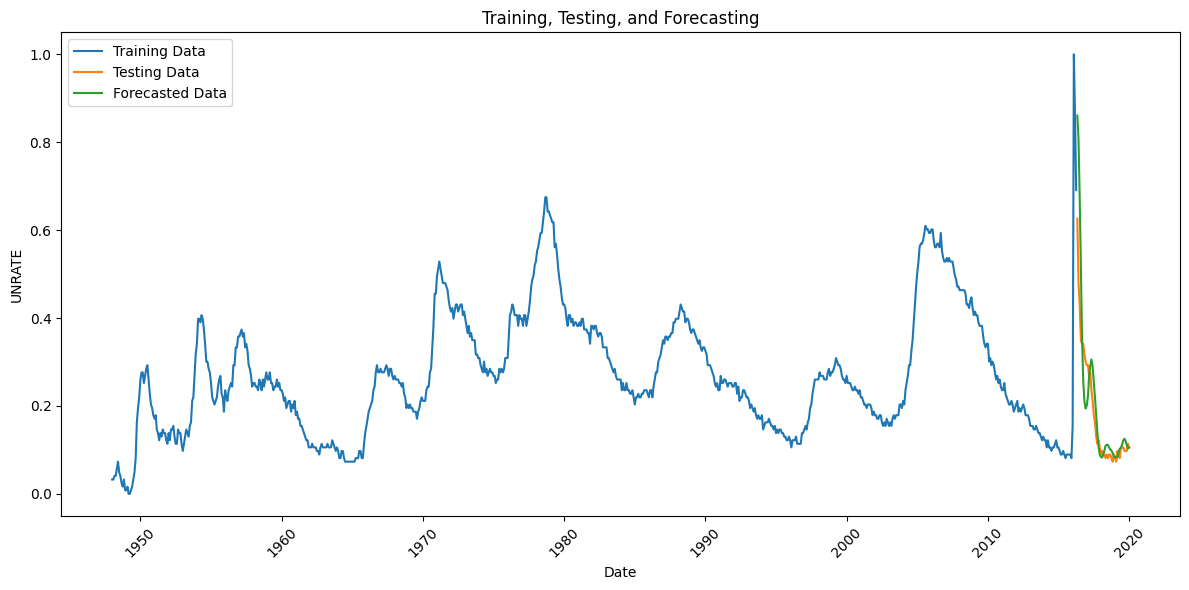

In [21]:
import matplotlib.pyplot as plt

# Convert torch tensors to numpy arrays for plotting
y_train_np = y_train.detach().numpy()
y_test_np = y_test.detach().numpy()
y_pred_np = y_pred.detach().numpy()

# Plot training data
plt.plot(train_df.index[:len(y_train_np)], y_train_np, label='Training Data')

# Plot testing data
plt.plot(train_df.index[len(y_train_np):len(y_train_np) + len(y_test_np)], y_test_np, label='Testing Data')

# Plot forecasted data
plt.plot(train_df.index[len(y_train_np):len(y_train_np) + len(y_pred_np)], y_pred_np, label='Forecasted Data')

plt.xlabel('Date')
plt.ylabel('UNRATE')
plt.title('Training, Testing, and Forecasting')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gcf().set_size_inches(12, 6)  # Set the size of the plot
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


## **Conclusion**

A Root Mean Squared Error (RMSE) value of approximately 1.04 suggests that the LSTM model performs quite well in predicting the Unemployment Rate values compared to other models like ARIMA, Prophet, AR, and MA. Lower RMSE values indicate better predictive performance, indicating that the LSTM model is relatively accurate in its forecasts.